In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

import nltk
import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

In [2]:
file1 = 'data/QueryResults3_new.csv'
df1 = pd.read_csv(file1,index_col=['Id'])

import mes_fonctions_final2 as stt

In [3]:
StopWord = stt.load_stop_word()

# Chargement des Tags
> Nous chargeons les tags transformés en Dummy features (une colonne par tag en binaire)
>
> Nous n'allons considérer que les tags cités au moins 300 fois (en dessous la représentation risque de n'être pas suffisamment bonne)

In [4]:
Y_tags, Y_tags_voc = stt.genere_target_dummy_and_vocabulary(data=df1, min_df=300)
Tags_freq = stt.genere_df_target_tags_freq(data=df1, min_df=300)

/!\ Ajout des features en cours


# Rappel des fonctions utiles

In [5]:
from nltk.stem.snowball import EnglishStemmer
stemmer = EnglishStemmer()

def preProcess_remove_Code(html_in):
    # Chargement du module BeautifulSoup pour le parsing des données HTML
    from bs4 import BeautifulSoup
    html_in_soup = BeautifulSoup(html_in, 'html.parser')

    # Suppression des blocs de Code
    for h_code in html_in_soup.find_all('code'):
        h_code.decompose()

    return html_in_soup.get_text().lower()


def preProcess_keep_Code(html_in):
    # Chargement du module BeautifulSoup pour le parsing des données HTML
    from bs4 import BeautifulSoup
    html_in_soup = BeautifulSoup(html_in, 'html.parser')

    return html_in_soup.get_text().lower()

# Le préprocessing :
#   - nettoie le html
#   - supprime les blocs de Code
#   - ne prend que la partie textuelle du html
#   - renvoie ce texte en minuscule


def preProcess(html_in):
    # Chargement du module BeautifulSoup pour le parsing des données HTML
    from bs4 import BeautifulSoup
    html_in_soup = BeautifulSoup(html_in, 'html.parser')

    # Suppression des blocs de Code
    for h_code in html_in_soup.find_all('code'):
        h_code.decompose()

    return html_in_soup.get_text().lower()


# Réalisation du stemming (on coupe les racines)
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed


# La tokenisation :


def tokenize(text):
    m_token_pattern = r"((?:(?:(?:[0-9a-zA-Z])\.){2,}[a-zA-Z])" +\
        "|(?:(?:[0-9a-zA-Z]){2,}\.(?:[0-9a-zA-Z]){2,}" +\
        "|(?:\.(?:[0-9a-zA-Z]){2,}))" +\
        "|[0-9a-zA-Z-\-\+\#]{2,}|w+)"

    from nltk.tokenize import RegexpTokenizer
    # Nous allons utiliser le pattern pour identifier les mots
    tokenizer = RegexpTokenizer(m_token_pattern)

    # Nous lançons la séparation des mots
    tokens = tokenizer.tokenize(text)

    # On fait appel au stemming pour rapprocher les mots de même racine
    stems = stem_tokens(tokens, stemmer)

    # Etape de nettoyage des valeurs :
    # Nous allons supprimer les nombres sans texte,
    def suppress_nb(x):
        import re
        if x is None:
            return None
        pattern = r'(^[\#\-\+]*[0-9]*$|' + '^[0-9]*[\#\-\+]*$|'+'^[0-9]*[\#\-\+]?[0-9]*$|'+'^[0-9\#\-\+][a-z]$|'+'^[a-z][0-9\#\-\+]$|'+'^[0-9]*\.[0-9]*$)'
        if not(re.match(pattern, x)):
            return x

    def nettoie_points(x):
        import re
        if x is None:
            return None

        if (re.match(r'(^[\.\-\#][a-z]*$)', x)):
            return ''.join(list(x)[1:])
        else:
            return x

    # Nous filtrons les nombres seuls
    stems = list(filter(lambda x: suppress_nb(x), stems))
    stems = [nettoie_points(x) for x in stems]
    return stems

# Séparation des données 
> On sépare nos données d'entrainement de celles de test avec un rapport 80 / 20

In [30]:
# On sépare les données d'entrainement de celles de tests
debut = datetime.datetime.now()
X = df1['Body']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_tags, test_size=0.2, random_state=42 )
fin = datetime.datetime.now()
print("Fin Train_Split : {}".format(fin-debut))

Fin Train_Split : 0:00:00.057806


# Quelle mesure ?
> Nous allons d'abord faire une modélisation rapide via une naive Bayes sur le tag 'python'

In [31]:
from sklearn.naive_bayes import MultinomialNB

# Estimateurs
vect_count = CountVectorizer(
        analyzer="word",
        # On fait varier la fréquence min pour la prise en compte des mots
        min_df=500,
        tokenizer=tokenize,
        # token_pattern=m_token_pattern,
        preprocessor=preProcess,
        stop_words=StopWord,        # Pas de stopWord car nous les cherchons
        ngram_range=(1, 6),   # Nous ne prenons que le 1-Gram
        )

tfidf = TfidfTransformer()

# Classifiers Naive Bayes
clf1 = MultinomialNB()
clf2 = MultinomialNB()

# 0 - Debut des Opérations: Préparation des données
debut_0 = datetime.datetime.now()

# 1 - On entraine et transforme via CountVectorizer
debut = datetime.datetime.now()
X_1 = vect_count.fit_transform(X_train)
fin = datetime.datetime.now()
print("Fin vect_count : {}".format(fin-debut))

# 2 - On fait la transformation TF-IDF
debut = datetime.datetime.now()
X_2 = tfidf.fit_transform(X_1)
fin = datetime.datetime.now()
print("Fin TF-IDF : {}".format(fin-debut))

# 3 - On entraine via le Naive Bayes 
# ## On le fait pour 2 tags : python (très fréquent) / ios (moins fréquent)
debut = datetime.datetime.now()
clf1.fit(X_2, Y_train['python'].to_dense().ravel())
clf2.fit(X_2, Y_train['ios'].to_dense().ravel())
fin = datetime.datetime.now()
print("Fin MODELISATION NAIVE BAYES : {}".format(fin-debut))

print('\nTOTAL {}'.format(fin-debut_0))

Fin vect_count : 0:01:21.310952
Fin TF-IDF : 0:00:00.011199
Fin MODELISATION NAIVE BAYES : 0:00:00.025342

TOTAL 0:01:21.347833


## Mesure de la modélisation
### Transformation de X via CountVectorizer et TF-IDF

In [32]:
# On transforme d'abord les données de X_test
debut_0 = datetime.datetime.now()

# 1- CountVectorizer
debut = datetime.datetime.now()
X_test_1 = vect_count.transform(X_test)
fin = datetime.datetime.now()
print("Fin CountVectorizer : {}".format(fin-debut))

# 2 - Tf-IDF
debut = datetime.datetime.now()
X_test_2 = tfidf.transform(X_test_1)
fin = datetime.datetime.now()
print("Fin Tf-IDF : {}".format(fin-debut))

Fin CountVectorizer : 0:00:16.089367
Fin Tf-IDF : 0:00:00.002489


### Prédiction Naive Bayes

In [33]:
# 3 - Modélisation Naives Bayes
debut = datetime.datetime.now()
Y_pred_python = clf1.predict(X_test_2)
Y_pred_ios = clf2.predict(X_test_2)

fin = datetime.datetime.now()
print("Fin PREDICTION -- Naives Bayes : {}".format(fin-debut))

Fin PREDICTION -- Naives Bayes : 0:00:00.002137


### Mesure par Accuracy

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix

print('Python Accuracy : {}\nIos Accuracy : {}'.format(
    accuracy_score(y_true=Y_test['python'].to_dense().ravel(), y_pred=Y_pred_python),
    accuracy_score(y_true=Y_test['ios'].to_dense().ravel(), y_pred=Y_pred_ios)))

Python Accuracy : 0.8912
Ios Accuracy : 0.9779


> Les résultats sont élevés : et très élevé pour IOS mais regardons la matrice de confusion

In [44]:
print('Matrice de Confusion de Python : \n{}'.format(
    confusion_matrix(y_true=Y_test['python'].to_dense().ravel(), y_pred=Y_pred_python)))

Matrice de Confusion de Python : 
[[8874    9]
 [1079   38]]


In [53]:
print('Matrice de Confusion de Ios : \n{}'.format(
    confusion_matrix(y_true=Y_test['ios'].to_dense().ravel(), y_pred=Y_pred_ios)))

Matrice de Confusion de Ios : 
[[9779    0]
 [ 221    0]]


On constate (comme c'est souvent le cas pour les classifications binaires) que les scores sont élevés mais ne sont pas représentatifs du problème.

- Très peu de tags ont été prédits pour python et aucun pour IOS (par défaut on a plutôt prédit la non présence) 
- Les faux sont les seules prédictions de présence du tag pour IOS, meilleur pour Python mais reste faible


- Nous avons donc besoin de mesurer en même temps
    - la sensibilité (recall en anglais) qui met en évidence, parmi les données réellement positives, le taux de prédiction par rapport au total des positives
    - la précision qui met en évidence, parmi les prédictions de 'Vrais', le taux de valeurs bonnes sur le total des prédites comme 'Vrai'
    

=> Une mesure est adaptée pour cela : c'est le F1-Score, moyenne harmonique de la sensibilité et de la précision qui met en évidence les faibles valeurs
> C'est cette mesure que nous allons utiliser pour la méthode supervisée pour chaque tag
> 
> Pour la mesure complète du modèle : nous ferons la moyenne de ces f1-score pour l'ensemble des tags

In [54]:
print('Python F1_score : {}\nIos F1_score : {}'.format(
    f1_score(y_true=Y_test['python'].to_dense().ravel(), y_pred=Y_pred_python),
    f1_score(y_true=Y_test['ios'].to_dense().ravel(), y_pred=Y_pred_ios)))

Python F1_score : 0.06529209621993126
Ios F1_score : 0.0


/Users/seb/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Bloc Code ou Non ?
> Nous relançons les tests sur python et IOS, cette fois en prenant en compte les bloc Code (nous avons vu dans la partie exploratoire que ceux-ci semblaient apporter des termes importants supplémentaires voyons s'ils apportent quelque chose à la modélisation)

In [56]:
from sklearn.naive_bayes import MultinomialNB

# Estimateurs
vect_count = CountVectorizer(
        analyzer="word",
        # On fait varier la fréquence min pour la prise en compte des mots
        min_df=500,
        tokenizer=tokenize,
        # token_pattern=m_token_pattern,
        preprocessor=preProcess_keep_Code,
        stop_words=StopWord,        # Pas de stopWord car nous les cherchons
        ngram_range=(1, 6),   # Nous ne prenons que le 1-Gram
        )

tfidf = TfidfTransformer()

# Classifiers Naive Bayes
clf1 = MultinomialNB()
clf2 = MultinomialNB()

# 0 - Debut des Opérations: Préparation des données
debut_0 = datetime.datetime.now()

# 1 - On entraine et transforme via CountVectorizer
debut = datetime.datetime.now()
X_1 = vect_count.fit_transform(X_train)
fin = datetime.datetime.now()
print("Fin vect_count : {}".format(fin-debut))

# 2 - On fait la transformation TF-IDF
debut = datetime.datetime.now()
X_2 = tfidf.fit_transform(X_1)
fin = datetime.datetime.now()
print("Fin TF-IDF : {}".format(fin-debut))

# 3 - On entraine via le Naive Bayes 
# ## On le fait pour 2 tags : python (très fréquent) / ios (moins fréquent)
debut = datetime.datetime.now()
clf1.fit(X_2, Y_train['python'].to_dense().ravel())
clf2.fit(X_2, Y_train['ios'].to_dense().ravel())
fin = datetime.datetime.now()
print("Fin MODELISATION NAIVE BAYES : {}".format(fin-debut))

print('\nTOTAL {}'.format(fin-debut_0))


# Nous allons mesurer

# On transforme d'abord les données de X_test
debut_0 = datetime.datetime.now()

# 1- CountVectorizer
debut = datetime.datetime.now()
X_test_1 = vect_count.transform(X_test)
fin = datetime.datetime.now()
print("Fin CountVectorizer : {}".format(fin-debut))

# 2 - Tf-IDF
debut = datetime.datetime.now()
X_test_2 = tfidf.transform(X_test_1)
fin = datetime.datetime.now()
print("Fin Tf-IDF : {}".format(fin-debut))

# Prédiction de Y
debut = datetime.datetime.now()
Y_pred_python = clf1.predict(X_test_2)
Y_pred_ios = clf2.predict(X_test_2)

fin = datetime.datetime.now()
print("Fin PREDICTION -- Naives Bayes : {}".format(fin-debut))

Fin vect_count : 0:02:47.570023
Fin TF-IDF : 0:00:00.025101
Fin MODELISATION NAIVE BAYES : 0:00:00.033560

TOTAL 0:02:47.629213
Fin CountVectorizer : 0:00:28.201522
Fin Tf-IDF : 0:00:00.007121
Fin PREDICTION -- Naives Bayes : 0:00:00.001983


In [66]:
import mes_fonctions_final22 as stt2

Y_pred_python, Y_pred_ios = stt2.test_diff_min_df(min_df=500,  
                 X_train=X_train, Y_train=Y_train, X_test=X_test, 
                 clf=MultinomialNB())

Fin vect_count : 0:02:48.266952
Fin TF-IDF : 0:00:00.019414
Fin MODELISATION NAIVE BAYES : 0:00:00.019161

TOTAL 0:02:48.305884
Fin CountVectorizer : 0:00:27.638228
Fin Tf-IDF : 0:00:00.004670
Fin PREDICTION -- Naives Bayes : 0:00:00.002112


In [67]:
print('Python F1_score : {}\nIos F1_score : {}'.format(
    f1_score(y_true=Y_test['python'].to_dense().ravel(), y_pred=Y_pred_python),
    f1_score(y_true=Y_test['ios'].to_dense().ravel(), y_pred=Y_pred_ios)))

Python F1_score : 0.30377906976744184
Ios F1_score : 0.017937219730941707


In [68]:
print('Matrice de Confusion de Python : \n{}'.format(
    confusion_matrix(y_true=Y_test['python'].to_dense().ravel(), y_pred=Y_pred_python)))
print('Matrice de Confusion de Ios : \n{}'.format(
    confusion_matrix(y_true=Y_test['ios'].to_dense().ravel(), y_pred=Y_pred_ios)))

Matrice de Confusion de Python : 
[[8833   50]
 [ 908  209]]
Matrice de Confusion de Ios : 
[[9779    0]
 [ 219    2]]


> On remarque que les résultats sont bien meilleurs avec la prise en compte du bloc Code : pour python d'abord 
> ensuite pour ios pour lequel nous avons réussi à prédire des valeurs
> 
> Nous allons donc le prendre en compte dans le reste de notre étude

## Changement de classifier : utilisons une Régression Logistic

In [72]:
from sklearn.linear_model import LogisticRegression

Y_pred_python, Y_pred_ios = stt2.test_diff_min_df(min_df=500,  
                 X_train=X_train, Y_train=Y_train, X_test=X_test, 
                 clf=LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial'))

Fin vect_count : 0:02:43.263679
Fin TF-IDF : 0:00:00.018442
Fin MODELISATION CLASSIFICATION : 0:00:01.539499

TOTAL 0:02:44.822251
Fin CountVectorizer : 0:00:27.562848
Fin Tf-IDF : 0:00:00.004766
Fin PREDICTION -- CLASSIFICATION : 0:00:00.000906


In [73]:
print('Python f1_score : {}\nIos Accuracy : {}'.format(
    f1_score(y_true=Y_test['python'].to_dense().ravel(), y_pred=Y_pred_python),
    f1_score(y_true=Y_test['ios'].to_dense().ravel(), y_pred=Y_pred_ios)))

Python f1_score : 0.6065573770491803
Ios Accuracy : 0.44236760124610597


> Les résultats sont nettement supérieurs

# Test sur le nombre de min_df
> Nous allons tester différentes valeurs de min_df sur tous les tags sélectionnés
>
> Nous allons ainsi pouvoir envisager une réduction dimensionnelle via la valeur min_df

In [79]:
imp.reload(stt2)

<module 'mes_fonctions_final22' from '/Users/seb/Workspace/Dev/Formation-OC/Formation-Data-Scientist/Projet6-Categoriser_Automatiquement_des_Questions/NoteBooks/PROJET_A_LIVRER/mes_fonctions_final22.py'>

In [81]:
m_liste_x = [50, 100, 200, 300, 500, 700, 1000, 1200, 1500]
l_pred = []

debut = datetime.datetime.now()
for i_min in m_liste_x:
    l_y_pred = stt2.test_diff_min_df_multi_colonnes(
        min_df=i_min,  
        X_train=X_train, Y_train=Y_train, X_test=X_test,
        clf=LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial'))
    l_pred.append(l_y_pred)

fin = datetime.datetime.now()
print("Fin PREDICTION -- Logistic : {}".format(fin-debut))    


#l_python_f1_score.append(f1_score(y_true=Y_test['python'].to_dense().ravel(), y_pred=Y_pred_python))
#l_ios_f1_score.append(f1_score(y_true=Y_test['ios'].to_dense().ravel(), y_pred=Y_pred_ios))

Fin vect_count : 0:02:44.025315
Fin TF-IDF : 0:00:00.034549
Fin CountVectorizer : 0:00:29.934199
Fin Tf-IDF : 0:00:00.009546
Fin MODELISATION CLASSIFICATION : 0:00:47.914604

TOTAL 0:04:01.919032
Fin vect_count : 0:02:44.126199
Fin TF-IDF : 0:00:00.028892
Fin CountVectorizer : 0:00:28.175389
Fin Tf-IDF : 0:00:00.007290
Fin MODELISATION CLASSIFICATION : 0:00:41.715845

TOTAL 0:03:54.054277
Fin vect_count : 0:02:48.744360
Fin TF-IDF : 0:00:00.024034
Fin CountVectorizer : 0:00:28.351252
Fin Tf-IDF : 0:00:00.006361
Fin MODELISATION CLASSIFICATION : 0:00:37.466096

TOTAL 0:03:54.592706
Fin vect_count : 0:02:48.195138
Fin TF-IDF : 0:00:00.021560
Fin CountVectorizer : 0:00:28.368259
Fin Tf-IDF : 0:00:00.005042
Fin MODELISATION CLASSIFICATION : 0:00:35.763993

TOTAL 0:03:52.354513
Fin vect_count : 0:02:46.885074
Fin TF-IDF : 0:00:00.019078
Fin CountVectorizer : 0:00:29.714400
Fin Tf-IDF : 0:00:00.005203
Fin MODELISATION CLASSIFICATION : 0:00:31.735900

TOTAL 0:03:48.360117
Fin vect_count : 0:0

In [82]:
l_pred_copie = l_pred.copy()

In [106]:
m_df_f1_score = pd.DataFrame(index=m_liste_x, columns=Y_train.columns.tolist())

for i, i_list_mindf in enumerate(m_liste_x):
    for j, col in enumerate(Y_train.columns.tolist()):
        m_df_f1_score.loc[i_list_mindf, col] = f1_score(
            y_true=Y_test[col].to_dense().ravel(), 
            y_pred=l_pred[i][j])

/Users/seb/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [122]:
m_df_f1_score.to_csv('Score_f1.csv', index=True)

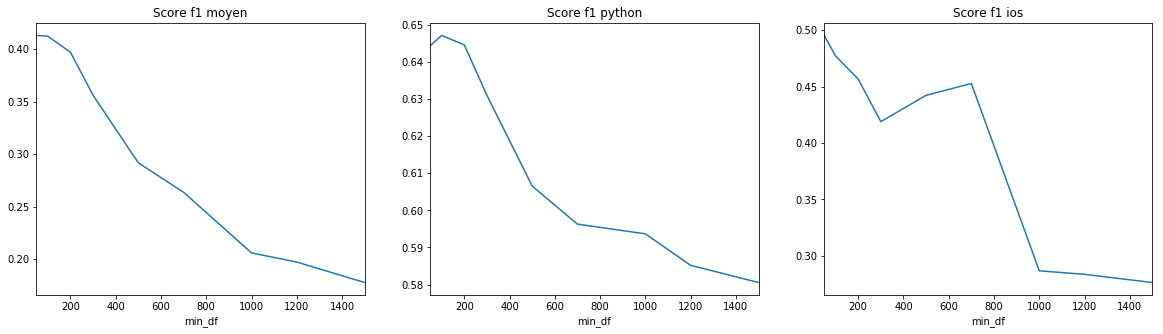

In [121]:
plt.figure(figsize=(20,5))

plt.subplot(131)
u1 = np.mean(m_df_f1, axis=1)
u1.plot(title='Score f1 moyen')
plt.xlabel('min_df')

plt.subplot(132)
u = m_df_f1['python']
u.plot(title='Score f1 python')
plt.xlabel('min_df')

plt.subplot(133)
v = m_df_f1['ios']
v.plot(title='Score f1 ios')
plt.xlabel('min_df')
plt.show()

> Nous constatons que le fait d'augmenter la valeur de min_df a une influence notable sur la note
>
> Nous allons prendre  min_df ayant pour valuer 100 et 700 

# Génération des valeurs de X_train et X_test

In [170]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

vect_tfidf = TfidfVectorizer(
    analyzer="word",
    min_df=100,
    max_df=0.2,
    tokenizer=tokenize,
    preprocessor=preProcess_keep_Code,
    stop_words=StopWord,        # Pas de stopWord car nous les cherchons
    ngram_range=(1, 6)
)

debut = datetime.datetime.now()
X_train2 = vect_tfidf.fit_transform(X_train)
X_test2 = vect_tfidf.transform(X_test)
fin = datetime.datetime.now()
print("Fin TfidfVectorizer : {}".format(fin-debut))

Fin TfidfVectorizer : 0:03:18.389859


## Recherche d'amélioration de la classification via l'hyperparametre C

In [166]:
imp.reload(stt2)

<module 'mes_fonctions_final22' from '/Users/seb/Workspace/Dev/Formation-OC/Formation-Data-Scientist/Projet6-Categoriser_Automatiquement_des_Questions/NoteBooks/PROJET_A_LIVRER/mes_fonctions_final22.py'>

In [157]:
#C_param_range = [0.001,0.01,0.1,1,10,100]

#param_grid = {'vect__min_df': m_liste_x}
from sklearn.model_selection import GridSearchCV

clf=LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

param_grid = {'C': [0.001,0.01,0.1,1,10,100],}

debut = datetime.datetime.now()
gs_clf = GridSearchCV(clf, cv=3, param_grid=param_grid, 
                      scoring='f1_micro', return_train_score=True, n_jobs=-1)

gs_clf.fit(X_train2.todense(), Y_train['python'].to_dense().ravel())
fin = datetime.datetime.now()
print("Fin GridSearch : {}".format(fin-debut))

Fin GridSearch : 0:02:29.475478


In [158]:
gs_clf.best_score_

0.9319

In [159]:
gs_clf.best_params_

{'C': 1}

In [160]:
gs_clf.cv_results_

{'mean_fit_time': array([ 1.59253971,  2.03948085,  3.43322913,  8.87528928, 13.80020102,
        10.56010954]),
 'mean_score_time': array([0.05876247, 0.05950538, 0.0568219 , 0.09531339, 0.09911807,
        0.05620503]),
 'mean_test_score': array([0.889875, 0.889925, 0.915875, 0.9319  , 0.930225, 0.922025]),
 'mean_train_score': array([0.889875  , 0.889925  , 0.91942503, 0.94256253, 0.95436252,
        0.95948753]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100}],
 'rank_test_score': array([6, 5, 4, 1, 2, 3], dtype=int32),
 'split0_test_score': array([0.88983051, 0.8899055 , 0.91240438, 0.92852857, 0.9279286 ,
        0.919904  ]),
 'split0_train_score': array([0.88989725, 0.88993475, 0.92211055, 0.94479862, 0.95578639,
        0.96156154]),
 'split1_test_score': ar

## Sur IOS

In [161]:
debut = datetime.datetime.now()
gs_clf.fit(X_train2.todense(), Y_train['ios'].to_dense().ravel())
fin = datetime.datetime.now()
print("Fin GridSearch : {}".format(fin-debut))

Fin GridSearch : 0:02:25.007508


In [162]:
gs_clf.best_score_

0.9809

In [163]:
gs_clf.best_params_

{'C': 10}

In [164]:
gs_clf.pr

True

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=2,
...                              random_state=0)

In [ ]:
gs_clf.predict()

In [169]:
X_train2.shape, X_test2.shape

((40000, 3089), (10000, 882))

## Pour tous les tags

In [171]:
clf=LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
param_grid = {'C': [0.001,0.01,0.1,1,10,100],}

debut = datetime.datetime.now()
l_clf, l_y_pred = stt2.test_gridSearch(X_train2, Y_train, X_test2, clf, param_grid)
fin = datetime.datetime.now()
print("Fin GridSearch : {}".format(fin-debut))

Fin MODELISATION CLASSIFICATION : 0:05:56.390567

TOTAL 0:05:56.390568
Fin GridSearch : 0:05:56.391934


In [206]:
m_df_logistic = pd.DataFrame(index=Y_train.columns.tolist(), columns=['f1_score', 'recall', 'C'])

for i_y_pred, col in enumerate(Y_train.columns.tolist()):
    #print(i_y_pred, col)
    m_df_logistic.loc[col, 'f1_score'] = f1_score(
        y_true=Y_test[col].to_dense().ravel(), 
        y_pred=l_pred[0][i_y_pred])
    
    m_df_logistic.loc[col, 'recall'] = recall_score(
        y_true=Y_test[col].to_dense().ravel(), 
        y_pred=l_pred[0][i_y_pred])
    
    m_df_logistic.loc[col, 'C'] = (l_clf[i_y_pred]).best_params_['C']
    #print(i_clf.best_score_)

In [407]:
m_df_logistic.head()

,f1_score,recall,C
.net,0.0243902,0.0126582,0.001
ajax,0.461538,0.318182,1
amazon-web-services,0.488189,0.364706,10
android,0.691796,0.589792,1
android-studio,0.12987,0.0735294,1


In [408]:
np.mean(m_df_logistic.f1_score), np.mean(m_df_logistic.recall),

(0.4129518192243252, 0.30580925184351093)

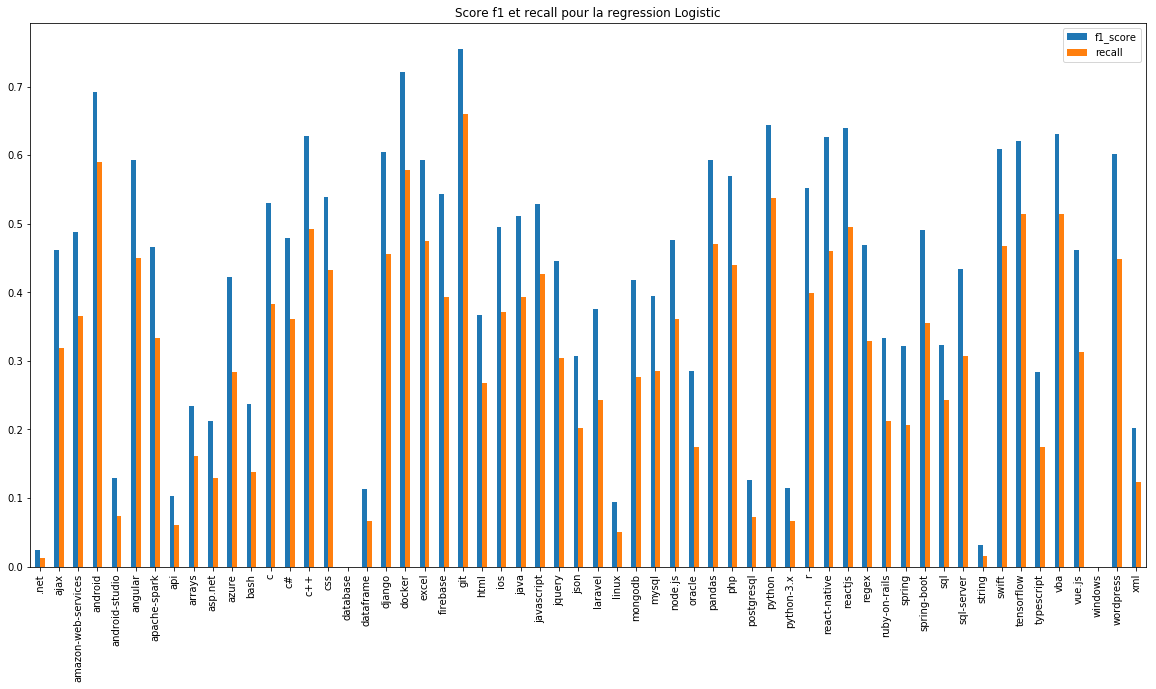

In [234]:
m_df_logistic[['f1_score', 'recall']].plot.bar(figsize=(20,10))
plt.title('Score f1 et recall pour la regression Logistic')
plt.show()

In [257]:
m_df_logistic.to_csv('SCORE_LOGISTIC.csv', index=True)

# Nouveaux Classifiers
## RandomForestClassifier

In [238]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=200,random_state=0)
param_grid = {}

debut = datetime.datetime.now()
gs_clf_V3 = GridSearchCV(clf, cv=3, param_grid=param_grid, 
                      scoring='f1_micro', return_train_score=True, n_jobs=-1)

gs_clf_V3.fit(X_train2.todense(), Y_train['python'].to_dense().ravel())
fin = datetime.datetime.now()
print("Fin GridSearch : {}".format(fin-debut))

Fin GridSearch : 0:06:21.971736


In [239]:
gs_clf_V3.best_score_

0.941875

> Le score pour python est bon : on va lancer cela sur tous les tags

In [334]:
clf_rfc = RandomForestClassifier(n_estimators=100, max_depth=40,random_state=0)
param_grid_rfc = {}

debut = datetime.datetime.now()
l_clf_rfc, l_y_pred_rfc = stt2.test_gridSearch(
    X_train2.todense(), Y_train, X_test2.todense(), 
    clf_rfc, param_grid_rfc)
fin = datetime.datetime.now()
print("Fin GridSearch : {}".format(fin-debut))

Col = .net, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:02:30.187614
Col = ajax, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:02:10.595104
Col = amazon-web-services, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:02:15.082020
Col = android, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:02:16.840457
Col = android-studio, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:02:28.056677
Col = angular, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:02:18.336163
Col = apache-spark, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:02:17.155309
Col = api, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:02:19.668411
Col = arrays, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:02:22.023324
Col = asp.net, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:02:33.481345
Col = azure, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:02:04.030772
Col = bash, y_pred.sh

In [347]:
df_body_random_forest = pd.DataFrame(l_y_pred_rfc).T

df_body_random_forest.index = Y_test.index
df_body_random_forest.columns = Y_test.columns

### Mesures

In [350]:
m_df_rfc = pd.DataFrame(index=Y_test.columns.tolist(), columns=['f1_score', 'recall', 'C'])

for i_y_pred, col in enumerate(Y_test.columns.tolist()):
    #print(i_y_pred, col)
    m_df_rfc.loc[col, 'f1_score'] = f1_score(
        y_true=Y_test[col].to_dense().ravel(), 
        y_pred=df_body_random_forest[col].to_dense().ravel())
    
    m_df_rfc.loc[col, 'recall'] = recall_score(
        y_true=Y_test[col].to_dense().ravel(), 
        y_pred=df_body_random_forest[col].to_dense().ravel())

/Users/seb/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


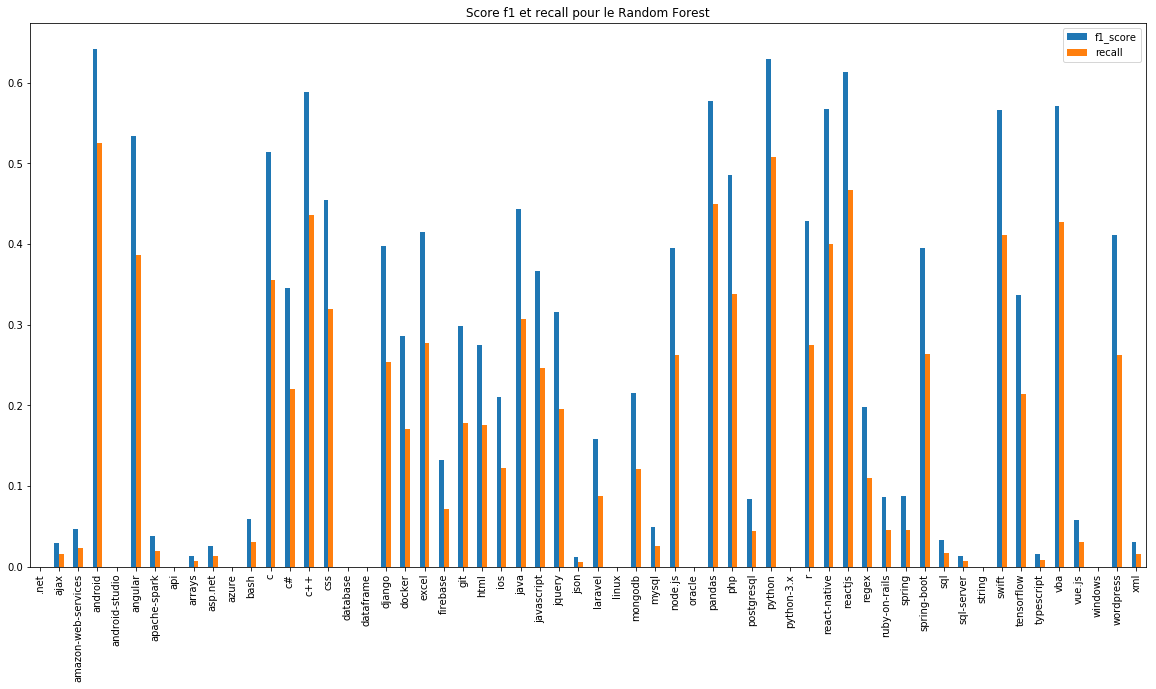

In [351]:
m_df_rfc[['f1_score', 'recall']].plot.bar(figsize=(20,10))
plt.title('Score f1 et recall pour le Random Forest')
plt.show()

In [352]:
np.mean(m_df_rfc.f1_score)

0.2317704559904378

In [355]:
np.mean(m_df_rfc.recall)

0.15843067545813186

> Les résultats sont moins bons que pour la Régression Logistic

In [353]:
m_df_rfc.to_csv('SCORE_RANDOM_FOREST.csv', index=True)

## Naives Bayes

In [354]:
clf_NB = MultinomialNB()
param_grid_NB = {}

debut = datetime.datetime.now()
l_clf_NB, l_y_pred_NB = stt2.test_gridSearch(
    X_train2.todense(), Y_train, X_test2.todense(), 
    clf_NB, param_grid_NB)
fin = datetime.datetime.now()
print("Fin GridSearch : {}".format(fin-debut))

Col = .net, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:16.818927
Col = ajax, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:17.344844
Col = amazon-web-services, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:16.264633
Col = android, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:16.802388
Col = android-studio, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:15.477729
Col = angular, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:15.760665
Col = apache-spark, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:16.649893
Col = api, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:17.513496
Col = arrays, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:15.738252
Col = asp.net, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:17.520909
Col = azure, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:16.068482
Col = bash, y_pred.sh

## Mesure

In [356]:
df_body_NB = pd.DataFrame(l_y_pred_NB).T

df_body_NB.index = Y_test.index
df_body_NB.columns = Y_test.columns

In [357]:
m_df_NB = pd.DataFrame(index=Y_test.columns.tolist(), columns=['f1_score', 'recall', 'C'])

for i_y_pred, col in enumerate(Y_test.columns.tolist()):
    #print(i_y_pred, col)
    m_df_NB.loc[col, 'f1_score'] = f1_score(
        y_true=Y_test[col].to_dense().ravel(), 
        y_pred=df_body_NB[col].to_dense().ravel())
    
    m_df_NB.loc[col, 'recall'] = recall_score(
        y_true=Y_test[col].to_dense().ravel(), 
        y_pred=df_body_NB[col].to_dense().ravel())

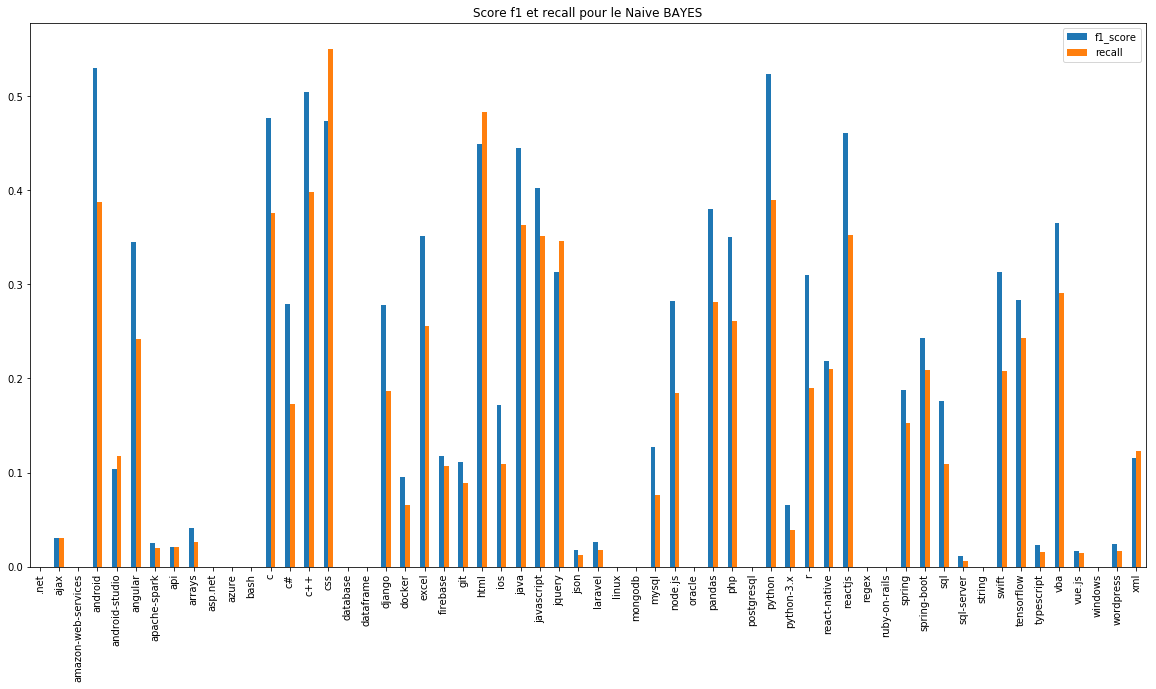

In [363]:
m_df_NB[['f1_score', 'recall']].plot.bar(figsize=(20,10))
plt.title('Score f1 et recall pour le Naive BAYES')
plt.show()

In [409]:
m_df_NB.to_csv('SCORE_NAIVE_BAYES.csv', index=True)

# Logistic2

In [359]:
clf_LR2 =LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr')
param_grid_LR2 = {'C': [0.001,0.01,0.1,1,10,100],}

debut = datetime.datetime.now()
l_clf_LR2, l_y_pred_LR2 = stt2.test_gridSearch(X_train2, Y_train, X_test2, clf_LR2, param_grid_LR2)
fin = datetime.datetime.now()
print("Fin GridSearch : {}".format(fin-debut))

Col = .net, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:03.542974
Col = ajax, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:03.969734
Col = amazon-web-services, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:03.647116
Col = android, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:04.094208
Col = android-studio, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:03.540012
Col = angular, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:03.981293
Col = apache-spark, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:03.598624
Col = api, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:03.573183
Col = arrays, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:03.787717
Col = asp.net, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:03.842236
Col = azure, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:03.540570
Col = bash, y_pred.sh

## Mesure

In [360]:
df_body_LR_2 = pd.DataFrame(l_y_pred_LR2).T

df_body_LR_2.index = Y_test.index
df_body_LR_2.columns = Y_test.columns

In [361]:
m_df_LR_2 = pd.DataFrame(index=Y_test.columns.tolist(), columns=['f1_score', 'recall', 'C'])

for i_y_pred, col in enumerate(Y_test.columns.tolist()):
    #print(i_y_pred, col)
    m_df_LR_2.loc[col, 'f1_score'] = f1_score(
        y_true=Y_test[col].to_dense().ravel(), 
        y_pred=df_body_LR_2[col].to_dense().ravel())
    
    m_df_LR_2.loc[col, 'recall'] = recall_score(
        y_true=Y_test[col].to_dense().ravel(), 
        y_pred=df_body_LR_2[col].to_dense().ravel())

/Users/seb/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


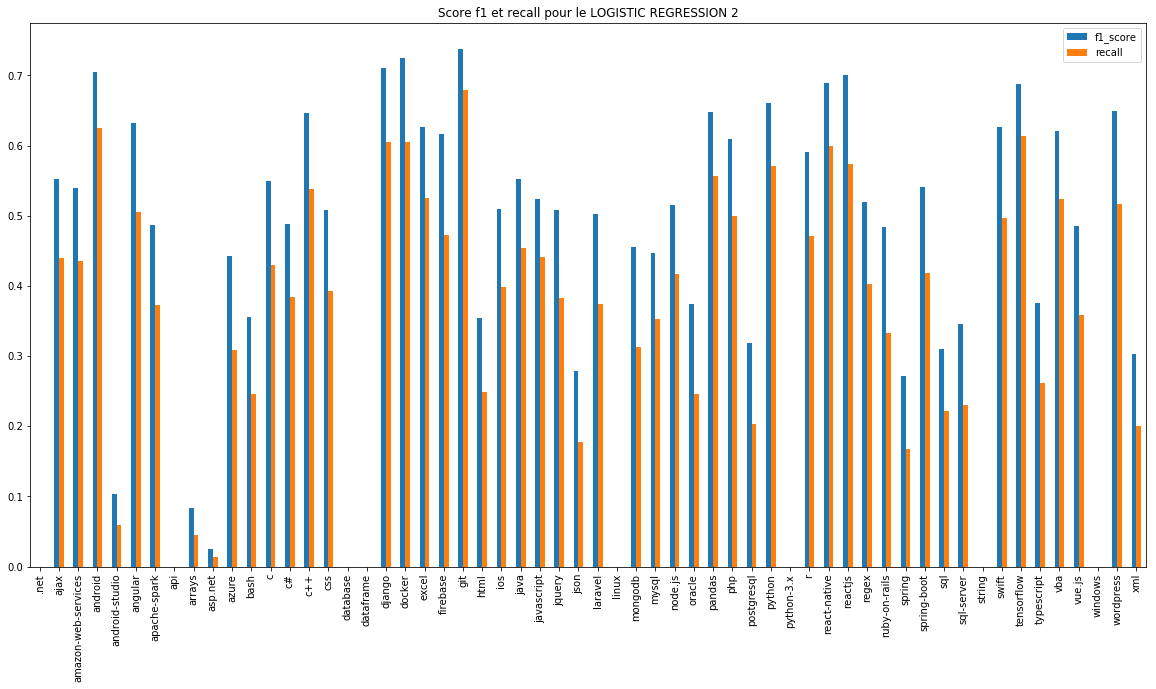

In [364]:
m_df_LR_2[['f1_score', 'recall']].plot.bar(figsize=(20,10))
plt.title('Score f1 et recall pour le LOGISTIC REGRESSION 2')
plt.show()

In [365]:
print(np.mean(m_df_LR_2), '\n\n', np.mean(m_df_LR_2))

f1_score    0.430939
recall      0.339829
C                NaN
dtype: float64 

 f1_score    0.430939
recall      0.339829
C                NaN
dtype: float64


In [410]:
m_df_LR_2.to_csv('SCORE_BODY_LOGISTIC2.csv', index=True)

# Title
> Nous reprenons le même travail (avec les valeurs optimisées par la Régression Logistic) pour le Titre

In [268]:
X = df1['Body']

X_train_Title = df1.loc[X_train.index, 'Title']
X_test_Title = df1.loc[X_test.index, 'Title']

In [267]:
X_train_Title.head()

Id
52710201                       Odoo add font pictogram widget
52729131    FFmpeg Processes keep running even after finis...
52696272      How to check Current ViewController in Swift 3?
52762482             Have html select always show same option
52768732    Importing multiple CSV files from Google Cloud...
Name: Title, dtype: object

In [270]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

vect_tfidf2 = TfidfVectorizer(
    analyzer="word",
    min_df=100,
    max_df=0.2,
    tokenizer=tokenize,
    preprocessor=preProcess_keep_Code,
    stop_words=StopWord,        # Pas de stopWord car nous les cherchons
    ngram_range=(1, 6)
)

debut = datetime.datetime.now()
X_train_Title2 = vect_tfidf2.fit_transform(X_train_Title)
X_test_Title2 = vect_tfidf2.transform(X_test_Title)
fin = datetime.datetime.now()
print("Fin TfidfVectorizer : {}".format(fin-debut))

Fin TfidfVectorizer : 0:00:12.346048


In [271]:
clf=LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
param_grid = {'C': [0.001,0.01,0.1,1,10,100],}

debut = datetime.datetime.now()
l_clf_title, l_y_pred_title = stt2.test_gridSearch(X_train_Title2, Y_train, X_test_Title2, clf, param_grid)
fin = datetime.datetime.now()
print("Fin GridSearch : {}".format(fin-debut))

Col = .net, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:03.007546
Col = ajax, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:03.211587
Col = amazon-web-services, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:03.293444
Col = android, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:03.413262
Col = android-studio, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:03.169918
Col = angular, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:03.001744
Col = apache-spark, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:02.886126
Col = api, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:03.116021
Col = arrays, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:03.150435
Col = asp.net, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:03.113105
Col = azure, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:03.009084
Col = bash, y_pred.sh

In [277]:
m_df_logistic_title = pd.DataFrame(index=Y_train.columns.tolist(), columns=['f1_score', 'recall', 'C'])

for i_y_pred, col in enumerate(Y_train.columns.tolist()):
    #print(i_y_pred, col)
    m_df_logistic_title.loc[col, 'f1_score'] = f1_score(
        y_true=Y_test[col].to_dense().ravel(), 
        y_pred=l_y_pred_title[i_y_pred])
    
    m_df_logistic_title.loc[col, 'recall'] = recall_score(
        y_true=Y_test[col].to_dense().ravel(), 
        y_pred=l_y_pred_title[i_y_pred])
    
    m_df_logistic_title.loc[col, 'C'] = (l_clf_title[i_y_pred]).best_params_['C']
    #print(i_clf.best_score_)

/Users/seb/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


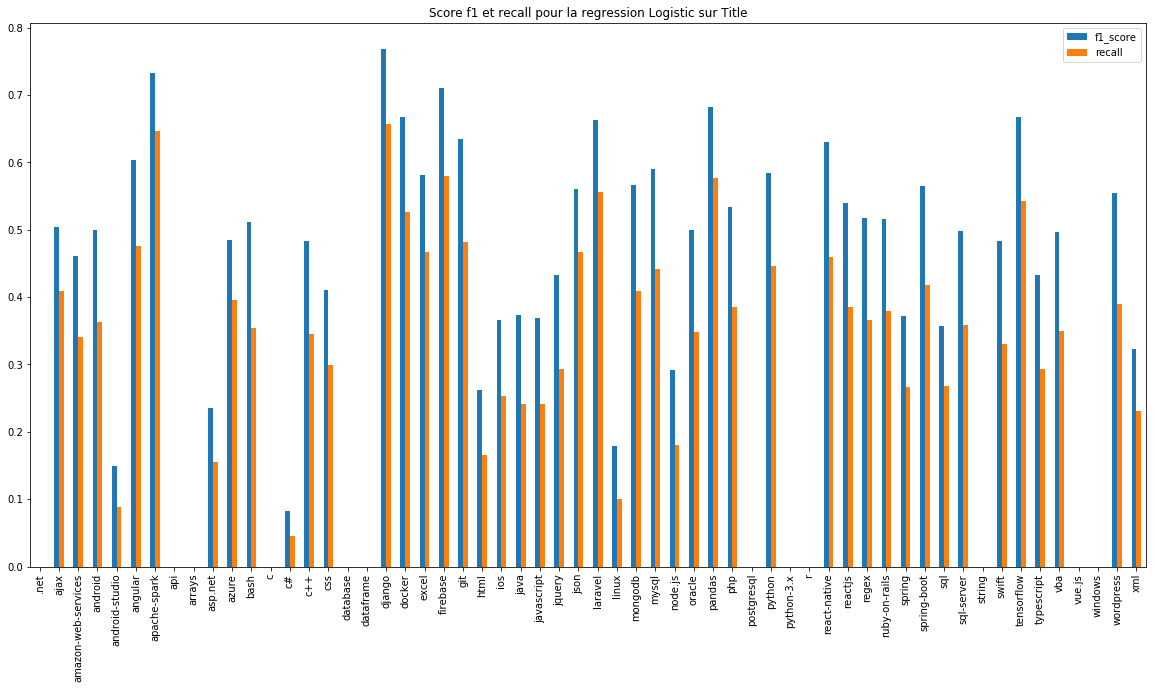

In [279]:
m_df_logistic_title[['f1_score', 'recall']].plot.bar(figsize=(20,10))
plt.title('Score f1 et recall pour la regression Logistic sur Title')
plt.show()

In [286]:
print(np.mean(m_df_logistic_title), '\n\n', np.mean(m_df_logistic))

f1_score    0.386681
recall      0.289257
C           6.689862
dtype: float64 

 f1_score    0.412952
recall      0.305809
C           4.588052
dtype: float64


## LOGISTIC2 

In [367]:
clf_LR2_Title=LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr')
param_grid_LR2_Title = {'C': [0.001,0.01,0.1,1,10,100],}

debut = datetime.datetime.now()
l_clf_title_LR2, l_y_pred_title_LR2 = stt2.test_gridSearch(X_train_Title2, Y_train, X_test_Title2, 
                                                   clf_LR2_Title, param_grid_LR2_Title)
fin = datetime.datetime.now()
print("Fin GridSearch : {}".format(fin-debut))

Col = .net, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:02.280908
Col = ajax, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:02.483175
Col = amazon-web-services, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:02.436267
Col = android, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:02.642584
Col = android-studio, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:02.504522
Col = angular, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:02.428186
Col = apache-spark, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:02.351790
Col = api, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:02.178476
Col = arrays, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:02.192826
Col = asp.net, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:02.427537
Col = azure, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:02.239519
Col = bash, y_pred.sh

### Mesures

In [368]:
df_title_LR_2 = pd.DataFrame(l_y_pred_title_LR2).T

df_title_LR_2.index = Y_test.index
df_title_LR_2.columns = Y_test.columns

In [369]:
m_df_title_LR_2 = pd.DataFrame(index=Y_test.columns.tolist(), columns=['f1_score', 'recall', 'C'])

for i_y_pred, col in enumerate(Y_test.columns.tolist()):
    #print(i_y_pred, col)
    m_df_title_LR_2.loc[col, 'f1_score'] = f1_score(
        y_true=Y_test[col].to_dense().ravel(), 
        y_pred=df_title_LR_2[col].to_dense().ravel())
    
    m_df_title_LR_2.loc[col, 'recall'] = recall_score(
        y_true=Y_test[col].to_dense().ravel(), 
        y_pred=df_title_LR_2[col].to_dense().ravel())

/Users/seb/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


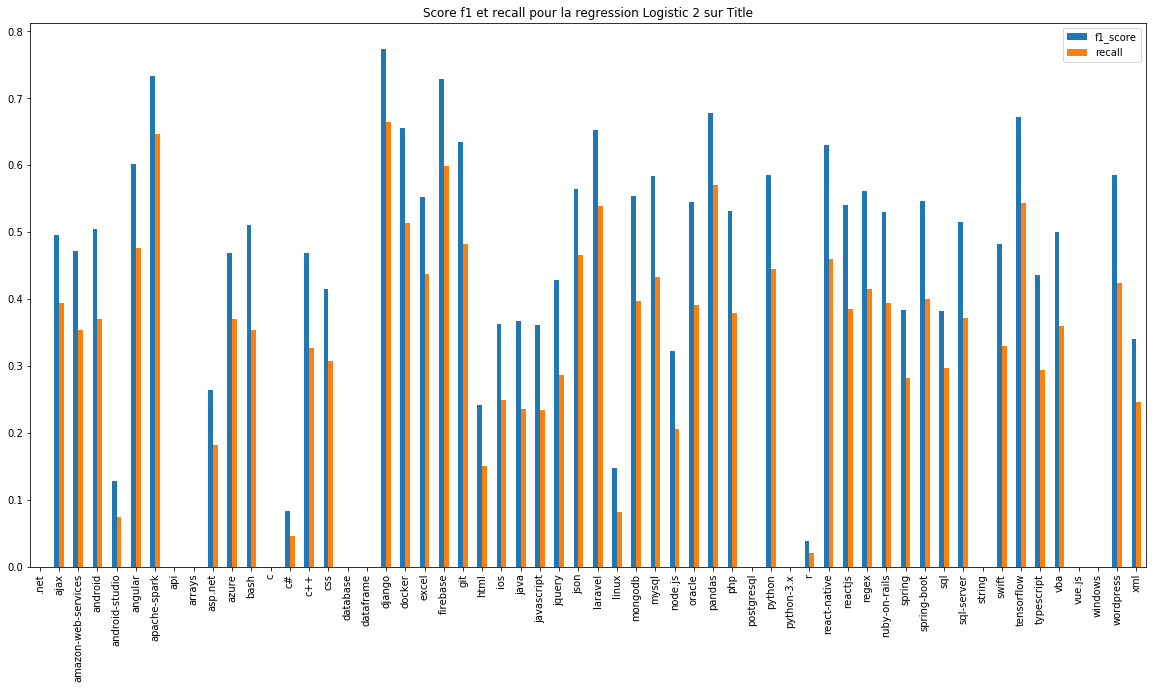

In [370]:
m_df_title_LR_2[['f1_score', 'recall']].plot.bar(figsize=(20,10))
plt.title('Score f1 et recall pour la regression Logistic 2 sur Title')
plt.show()

In [411]:
m_df_title_LR_2.to_csv('SCORE_TITLE_LOGISTIC2.csv', index=True)

# MODELISATION TITLE OR BODY

> Nous avons des score de recall qui sont assez bons pour le Body et aussi pour le Titre
>
> Si ces 2 scores étaient bons pour des POSTS différents cela nous donnerait quelque chose de meilleur encore.

> Nous pouvons supposer que les utilisateurs vont donner des informations, soit dans le titre soit dans le Corps
> 
> Si c'est bien le cas un OU entre les 2 modélisation est à tester

In [395]:
df_body_OR_title_LR_2 = pd.DataFrame(np.where(np.logical_or(df_body_LR_2, df_title_LR_2), 1, 0),
                                     columns=df_body_LR_2.columns, index=df_body_LR_2.index)                       

In [398]:
m_df_logistic_title_and_body2 = pd.DataFrame(index=Y_train.columns.tolist(), 
                                             columns=['f1_score', 'recall', 'C'])

for i_y_pred, col in enumerate(Y_train.columns.tolist()):
    #print(i_y_pred, col)
    m_df_logistic_title_and_body2.loc[col, 'f1_score'] = f1_score(
        y_true=Y_test[col].to_dense().ravel(), 
        y_pred=df_body_OR_title_LR_2[col].ravel())
    
    m_df_logistic_title_and_body2.loc[col, 'recall'] = recall_score(
        y_true=Y_test[col].to_dense().ravel(), 
        y_pred=df_body_OR_title_LR_2[col].ravel())

/Users/seb/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


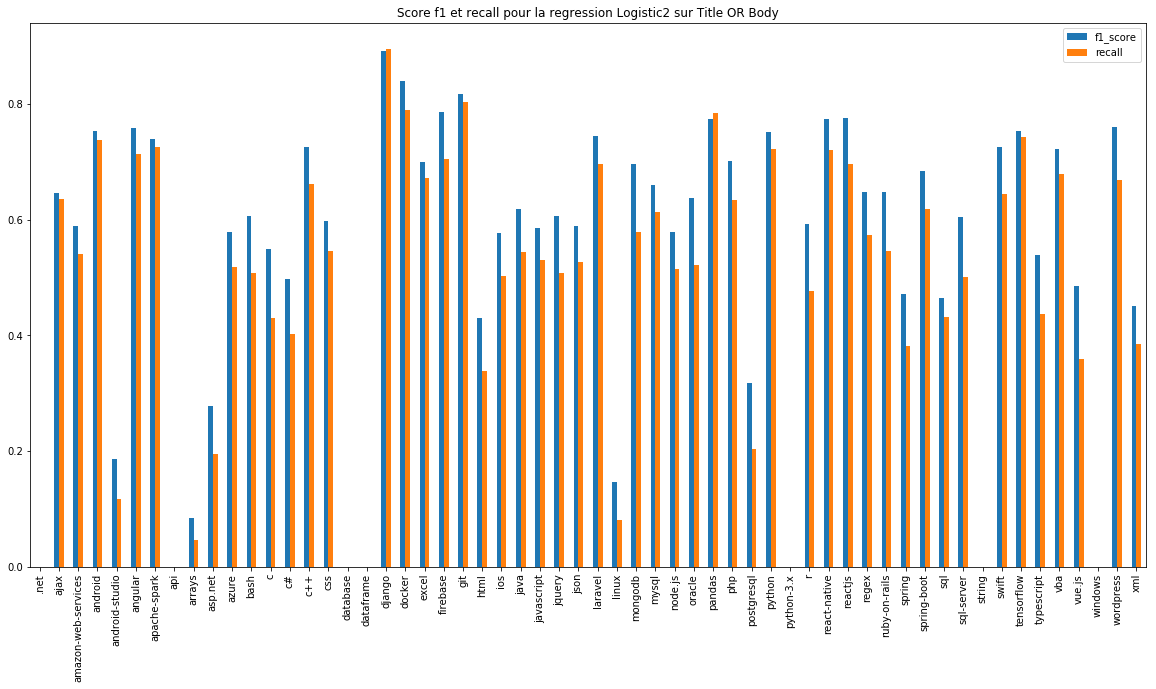

In [399]:
m_df_logistic_title_and_body2[['f1_score', 'recall']].plot.bar(figsize=(20,10))
plt.title('Score f1 et recall pour la regression Logistic2 sur Title OR Body')
plt.show()

In [412]:
m_df_logistic_title_and_body2.to_csv('SCORE_TITLE_AND_BODY_LOGISTIC2.csv', index=True)

> Les scores sont effectivement meilleurs et cela n'a pas dégradé la valeur f1_score

In [391]:
print('Score moyen des F1')
print('Pour le titre\n', np.mean(m_df_title_LR_2.f1_score), 
      '\n\nPour le Body\n', np.mean(m_df_LR_2.f1_score), 
      '\n\nPour le OR entre les 2 modélisations\n', 
      np.mean(m_df_logistic_title_and_body2.f1_score))

Score moyen des F1
Pour le titre
 0.3889583030807138 

Pour le Body
 0.43093912159062536 

Pour le OR entre les 2 modélisations
 0.53686612706268


In [390]:
print('Score moyen des recall')
print('Pour le titre\n', np.mean(m_df_title_LR_2.recall), 
      '\n\nPour le Body\n', np.mean(m_df_LR_2.recall), 
      '\n\nPour le OR entre les 2 modélisations\n', 
      np.mean(m_df_logistic_title_and_body2.recall))

Score moyen des recall
Pour le titre
 0.29103081212514303 

Pour le Body
 0.3398286013097282 

Pour le OR entre les 2 modélisations
 0.4793234908224303


## Mesure de Comparaison du Modèle

> Nous pouvons désormais considerer ce modèle et ajouter une mesure qui nous permettra de comparer avec la méthode non supervisée
>
> Pour cela il peut sembler judicieux de compter le nombre de tags (ou plutôt le pourcentage) valables pour chaque POST, ainsi nous établirons la moyenne de ce pourcentage pour la Note finale 

In [405]:
# Nombre de Tags moyens justes
u1 = np.sum(df_body_OR_title_LR_2==Y_test.to_dense(), axis=1)
np.mean(u1)

57.242

In [406]:
# Moyenne des taux de Tags justes
u1 = np.sum(df_body_OR_title_LR_2==Y_test.to_dense(), axis=1)/(len(Y_test.columns.tolist()))
np.mean(u1)

0.9869310344827549

# Mise en forme des résultats des Classifiers

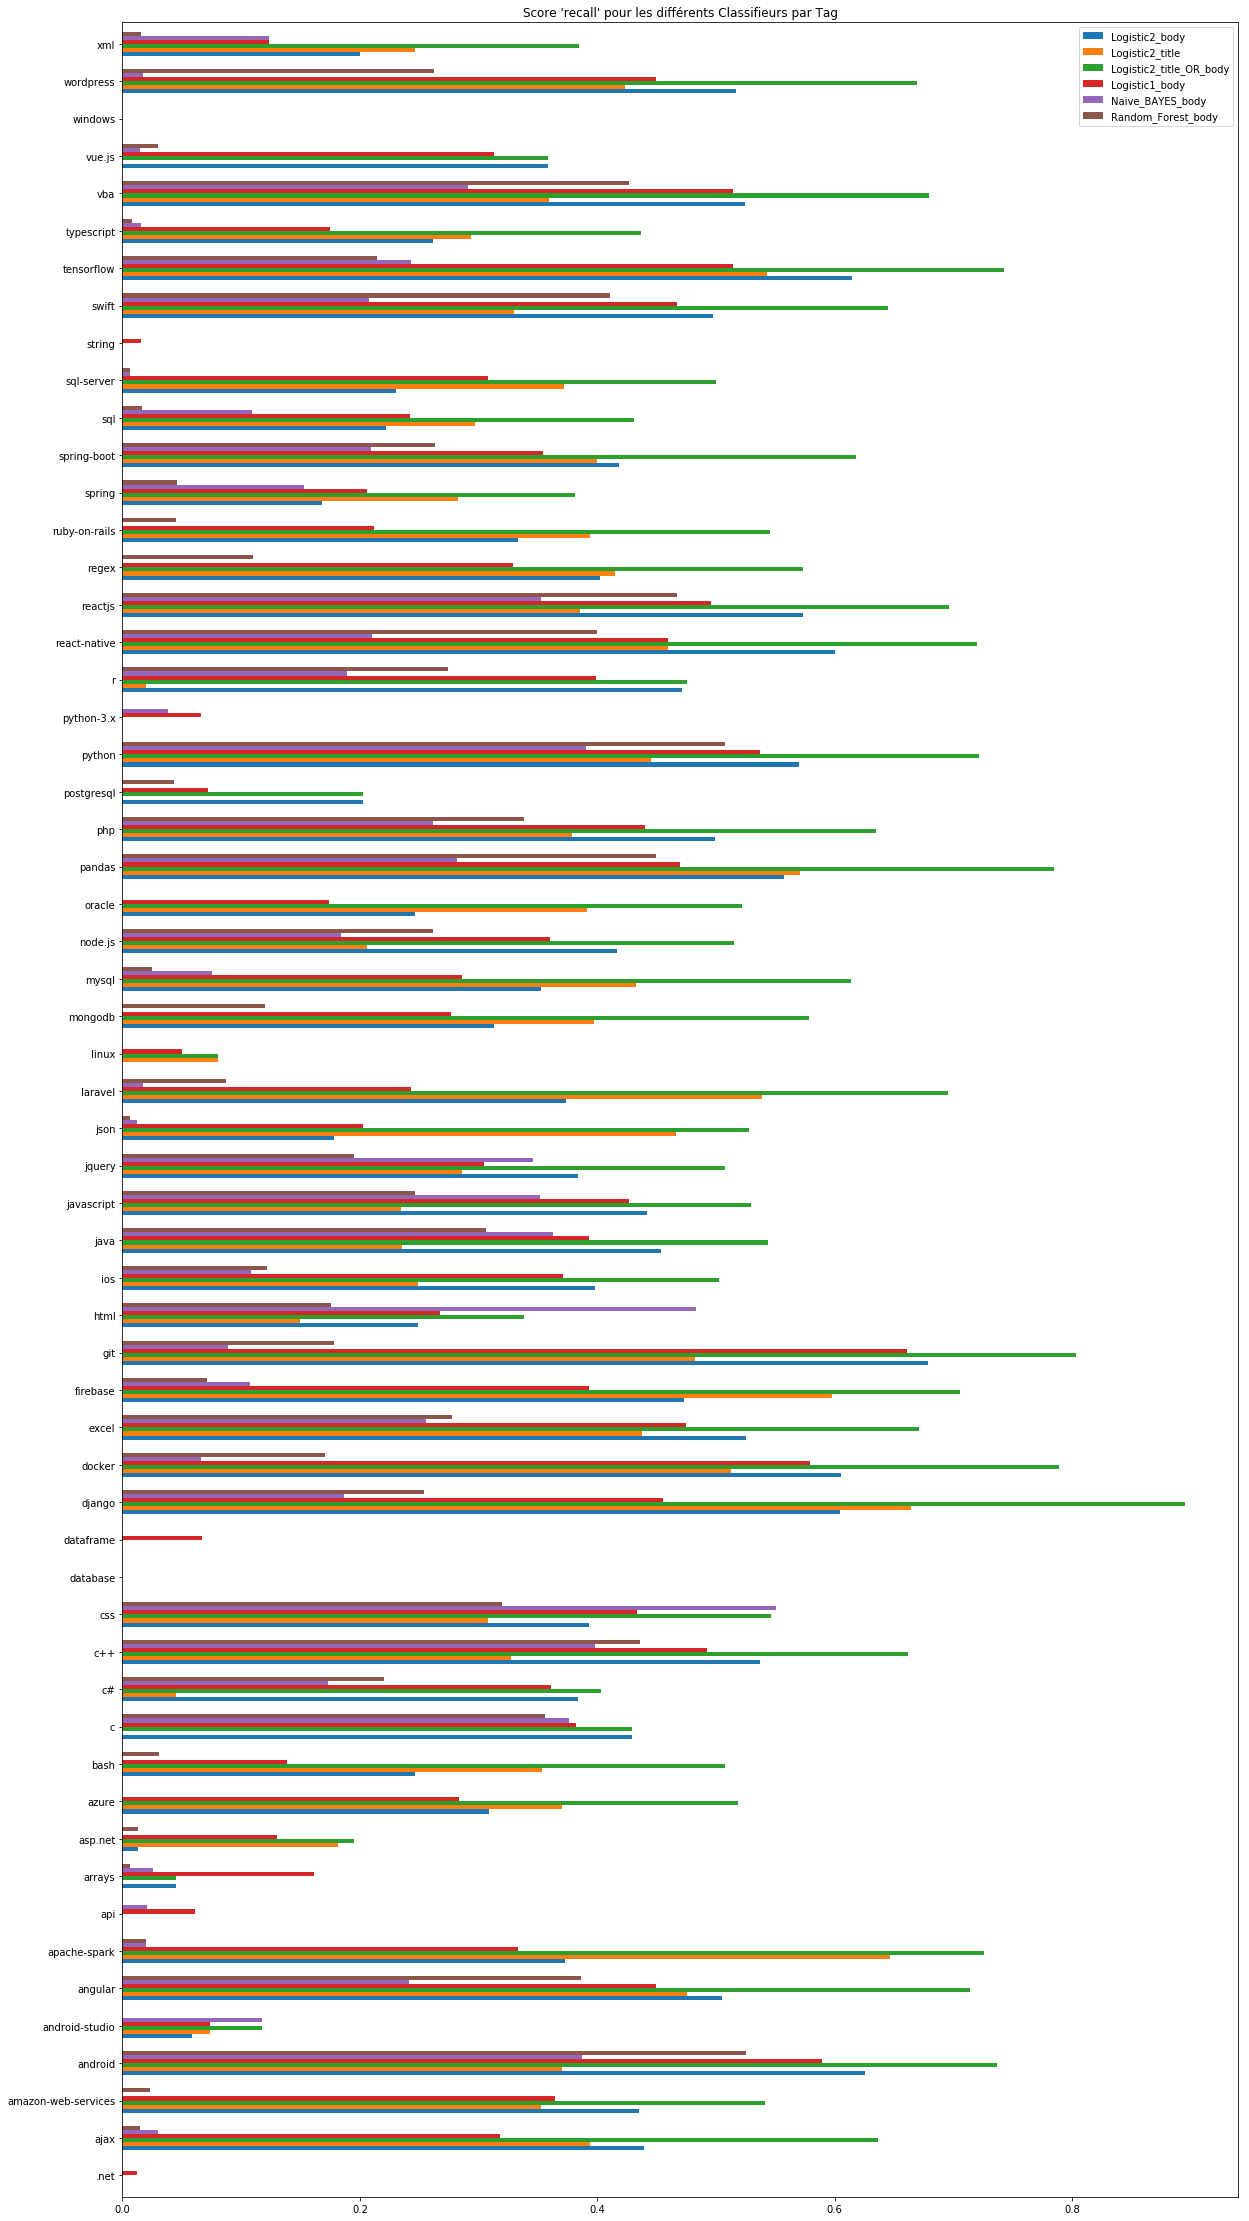

In [421]:
g_df_BODY_LR2 = pd.read_csv('SCORE_BODY_LOGISTIC2.csv', index_col=['Unnamed: 0'])[['f1_score', 'recall']]
g_df_TITLE_LR2 = pd.read_csv('SCORE_TITLE_LOGISTIC2.csv', index_col=['Unnamed: 0'])[['f1_score', 'recall']]
g_df_BODY_AND_TITLE_LR2 = pd.read_csv('SCORE_TITLE_AND_BODY_LOGISTIC2.csv', 
                                    index_col=['Unnamed: 0'])[['f1_score', 'recall']]
g_df_BODY_LR = pd.read_csv('SCORE_LOGISTIC.csv', index_col=['Unnamed: 0'])[['f1_score', 'recall']]
g_df_BODY_NB = pd.read_csv('SCORE_NAIVE_BAYES.csv', index_col=['Unnamed: 0'])[['f1_score', 'recall']]
g_df_BODY_RF = pd.read_csv('SCORE_RANDOM_FOREST.csv', index_col=['Unnamed: 0'])[['f1_score', 'recall']]

TOTAL = pd.concat(
    [
        g_df_BODY_LR2[['recall']], 
        g_df_TITLE_LR2[['recall']],
        g_df_BODY_AND_TITLE_LR2[['recall']], 
        g_df_BODY_LR[['recall']],
        g_df_BODY_NB[['recall']],
        g_df_BODY_RF[['recall']],
    ], axis=1)
TOTAL.columns = ['Logistic2_body', 'Logistic2_title', 'Logistic2_title_OR_body', 
                'Logistic1_body', 'Naive_BAYES_body', 'Random_Forest_body']

TOTAL.plot.barh(figsize=(20,40), width=0.65)
plt.title("Score 'recall' pour les différents Classifieurs par Tag")
plt.show()

# MODELE